# Infino - OpenAI LLM Monitoring Example

This example shows how one can track the following while calling OpenAI models via API:
* prompt input,
* response from chatgpt or any other OpenAI model,
* latency,
* errors,
* number of tokens consumed

In [2]:
# Install necessary dependencies.
!pip install matplotlib
!pip install openai
!pip install infinopy

import datetime as dt
from infinopy import InfinoClient
import json
import matplotlib.pyplot as plt
import matplotlib.dates as md
import openai
import time
import sys

  Using cached infinopy-0.0.1-py3-none-any.whl (3.4 kB)


## Start Infino server, initialize the Infino client


In [23]:
# Start server using the Infino docker image.
!docker run --rm --detach --name infino-example -p 3000:3000 infinohq/infino:latest

# Create Infino client.
client = InfinoClient()

eed320931566dd9ec939cea5c4aa68df87260540c61bf74939fd60f0742061a3


## Read the questions dataset

In [24]:
# Read the questions. These are a subset of questions from Stanford's QA dataset - 
# https://rajpurkar.github.io/SQuAD-explorer/
fh = open("../datasets/stanford-qa-subset.txt")
lines = fh.readlines()
fh.close()

questions = []
for line in lines:
  if not line.startswith("#"):
    questions.append(line.strip())

## OpenAI Q&A; Publish metrics and logs to Infino

In [25]:
# Set the model to be used while querying OpenAI.
GPT_MODEL = 'gpt-3.5-turbo'

# Set your key here. Or, it can also be set in ‘OPENAI_API_KEY’ environment variable.
#openai.api_key = "YOUR_API_KEY"

# Number of questions to ask the OpenAI model. We limit to a short number here to save $$ while running this demo.
num_questions = 10

questions = questions[0:num_questions]
question_id = 0
for question in questions:
    payload = {"date": int(time.time()), "prompt_question": question}
    client.append_log(payload)
    
    start = time.time()
    print(question)

    response = None
    is_error = 0
    try:
      # We send the question to OpenAI api and ask to limit to 2 sentences, mainly to save $$.
      response = openai.ChatCompletion.create(
          messages=[
              {'role': 'system', 'content': 'You answer the questions asked in maximum 2 sentences.'},
              {'role': 'user', 'content': question},
          ],
          model=GPT_MODEL,
          temperature=0,
      )
    except Exception as e:
      is_error = 1
      print("Error from OpenAI: ", e)

    end = time.time()
    duration = end-start
    payload = {"date": int(time.time()), "latency": duration, "labels": {"model": GPT_MODEL, "id": question_id}}
    client.append_ts(payload)
    
    payload = {"date": int(time.time()), "error": is_error, "labels": {"model": GPT_MODEL, "id": question_id}}
    client.append_ts(payload)
    
    if not is_error:
      payload = {"date": int(time.time()), "prompt_response": response['choices'][0]['message']['content']}
      print("Indexing payload", payload)
      client.append_log(payload)
      
      payload = {"date": int(time.time()), "prompt_tokens": response['usage']['prompt_tokens']}
      client.append_ts(payload)
      
      payload = {"date": int(time.time()), "completion_tokens": response['usage']['completion_tokens']}
      client.append_ts(payload)
      
      payload = {"date": int(time.time()), "total_tokens": response['usage']['total_tokens']}
      client.append_ts(payload)

In what country is Normandy located?
Indexing payload {'date': 1686570153, 'prompt_response': 'Normandy is located in France.'}
When were the Normans in Normandy?
Indexing payload {'date': 1686570154, 'prompt_response': 'The Normans were in Normandy from the 10th century until the late 11th century.'}
From which countries did the Norse originate?
Indexing payload {'date': 1686570156, 'prompt_response': 'The Norse originated from modern-day Denmark, Norway, and Sweden.'}
Who was the Norse leader?
Indexing payload {'date': 1686570157, 'prompt_response': 'There were many Norse leaders throughout history, including famous figures such as Ragnar Lothbrok, Harald Fairhair, and Erik the Red.'}
What century did the Normans first gain their separate identity?
Indexing payload {'date': 1686570159, 'prompt_response': 'The Normans first gained their separate identity in the 10th century.'}
Who gave their name to Normandy in the 1000's and 1100's
Indexing payload {'date': 1686570161, 'prompt_respon

## Create Metric Charts

We now use matplotlib to create graphs of latency, errors and tokens consumed.

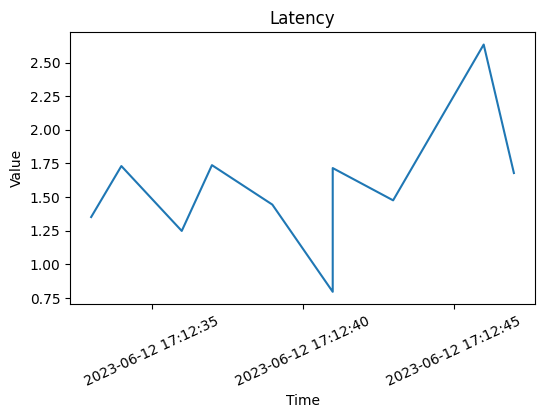

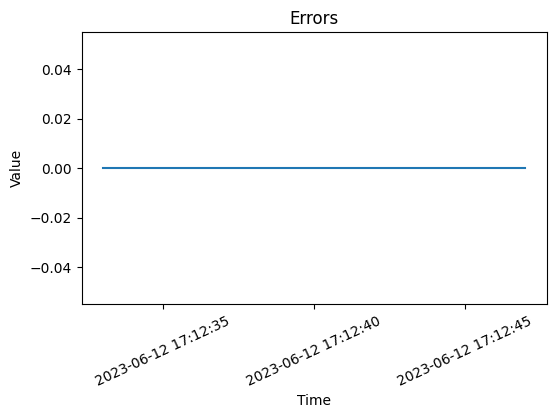

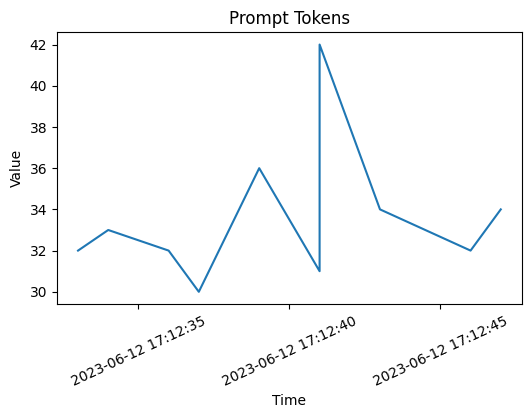

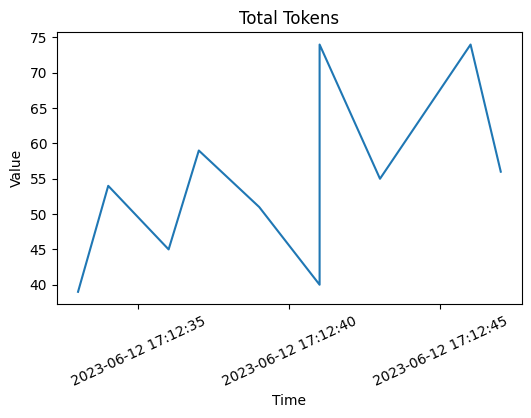

In [26]:
# Helper function to create a graph using matplotlib.
def plot(data, title):
  data = json.loads(data)

  # Extract x and y values from the data
  timestamps = [item["time"] for item in data]
  dates=[dt.datetime.fromtimestamp(ts) for ts in timestamps]
  y = [item["value"] for item in data]

  plt.rcParams['figure.figsize'] = [6, 4]
  plt.subplots_adjust(bottom=0.2)
  plt.xticks(rotation=25 )
  ax=plt.gca()
  xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
  ax.xaxis.set_major_formatter(xfmt)
  
  # Create the plot
  plt.plot(dates, y)

  # Set labels and title
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.title(title)

  plt.show()

response = client.search_ts("__name__", "latency", 0, int(time.time()))
plot(response.text, "Latency")

response = client.search_ts("__name__", "error", 0, int(time.time()))
plot(response.text, "Errors")

response = client.search_ts("__name__", "prompt_tokens", 0, int(time.time()))
plot(response.text, "Prompt Tokens")

response = client.search_ts("__name__", "total_tokens", 0, int(time.time()))
plot(response.text, "Total Tokens")


## Full text query on prompt or prompt outputs.

In [27]:
# Search for a particular prompt text.
query = "normandy"
response = client.search_log(query, 0, int(time.time()))
print("Results for", query, ":", response.text)

print("===")

query = "king charles III"
response = client.search_log("france.", 0, int(time.time()))
print("Results for", query, ":", response.text)


Results for normandy : [{"time":1686570151,"fields":{"prompt_question":"In what country is Normandy located?"},"text":"In what country is Normandy located?"},{"time":1686570153,"fields":{"prompt_response":"Normandy is located in France."},"text":"Normandy is located in France."},{"time":1686570154,"fields":{"prompt_response":"The Normans were in Normandy from the 10th century until the late 11th century."},"text":"The Normans were in Normandy from the 10th century until the late 11th century."},{"time":1686570159,"fields":{"prompt_question":"Who gave their name to Normandy in the 1000's and 1100's"},"text":"Who gave their name to Normandy in the 1000's and 1100's"},{"time":1686570161,"fields":{"prompt_response":"The Normans, a group of Vikings who settled in the region, gave their name to Normandy in the 1000's and 1100's."},"text":"The Normans, a group of Vikings who settled in the region, gave their name to Normandy in the 1000's and 1100's."}]
===
Results for king charles III : [{"t

## Step 5: Stop infino server

In [28]:
!docker rm -f infino-example

infino-example
